In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.stats import norm, pearsonr
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from collections import namedtuple
from math import sqrt

In [62]:
xls_name = "./fep-vs-gti-d-g-si.xlsx"
df_dict = pd.read_excel(xls_name,sheet_name=None,header=None)

In [63]:
def get_data_from_sheet(df_dict, sheet_name, col_names):
    df = df_dict[sheet_name]
    df = df[df.columns[15:18]]
    col_names = ["Experimental_dG","FEP_dG","TI_dG"]
    df.columns = col_names
    df = df.dropna()
    df = df.query("Experimental_dG > -20")
    rows,_ = df.shape
    df.insert(0,"Target",[sheet_name]*rows)
    df.insert(1,"ID",[f"{sheet_name}_{x}" for x in range(0,rows)])
    return df

In [64]:
pd.options.display.float_format = '{:,.2f}'.format

In [65]:
sheet_names = df_dict.keys()
col_names = ["Experimental_dG", "FEP_dG", "TI_dG"]

df_list = []
for sheet in sheet_names:
    tmp_df = get_data_from_sheet(df_dict, sheet, col_names)
    df_list.append(tmp_df)

big_df = pd.concat(df_list, ignore_index=True)
big_df.sort_values("Target", inplace=True)

In [66]:
big_df.head()

,Target,ID,Experimental_dG,FEP_dG,TI_dG
99,bace,bace_12,-8.53,-6.76,-8.27
117,bace,bace_30,-7.84,-7.40,-7.40
116,bace,bace_29,-9.01,-7.93,-7.80
115,bace,bace_28,-8.25,-7.01,-9.72
114,bace,bace_27,-9.10,-10.14,-10.16


In [67]:
mdf = big_df.melt(id_vars=["Target","ID","Experimental_dG"])
mdf["DataSet"] = mdf.Target + "_" + mdf.variable.str.replace("_dG","")
mdf.sort_values("DataSet",inplace=True)
cols = list(mdf.columns)
cols[4] = "Predicted_dG"
mdf.columns = cols

In [68]:
mdf.head()

,Target,ID,Experimental_dG,variable,Predicted_dG,DataSet
0,bace,bace_12,-8.53,FEP_dG,-6.76,bace_FEP
20,bace,bace_10,-9.69,FEP_dG,-9.38,bace_FEP
21,bace,bace_9,-8.72,FEP_dG,-8.73,bace_FEP
22,bace,bace_0,-8.83,FEP_dG,-8.82,bace_FEP
23,bace,bace_1,-9.11,FEP_dG,-8.90,bace_FEP


In [69]:
def draw_dG_facet(data, x, y, skip_text=False, **kwargs):
    xlim, ylim = np.array([[-15, -4], [-15, -4]])
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        ax = sns.scatterplot(data=data, x=x, y=y, **kwargs)

    r2 = pearsonr(data[x], data[y])[0]**2
    pad = 2
    if not skip_text:
        ax.text(-14, -6, f"$R^2$={r2:.2f}")
    ax.plot(xlim, ylim, linewidth=2, color='blue')
    ax.plot(xlim, ylim + pad, color="black", linestyle="--")
    ax.plot(xlim, ylim - pad, color="black", linestyle="--")
    ax.set(xlim=xlim, ylim=ylim)

In [70]:
import warnings

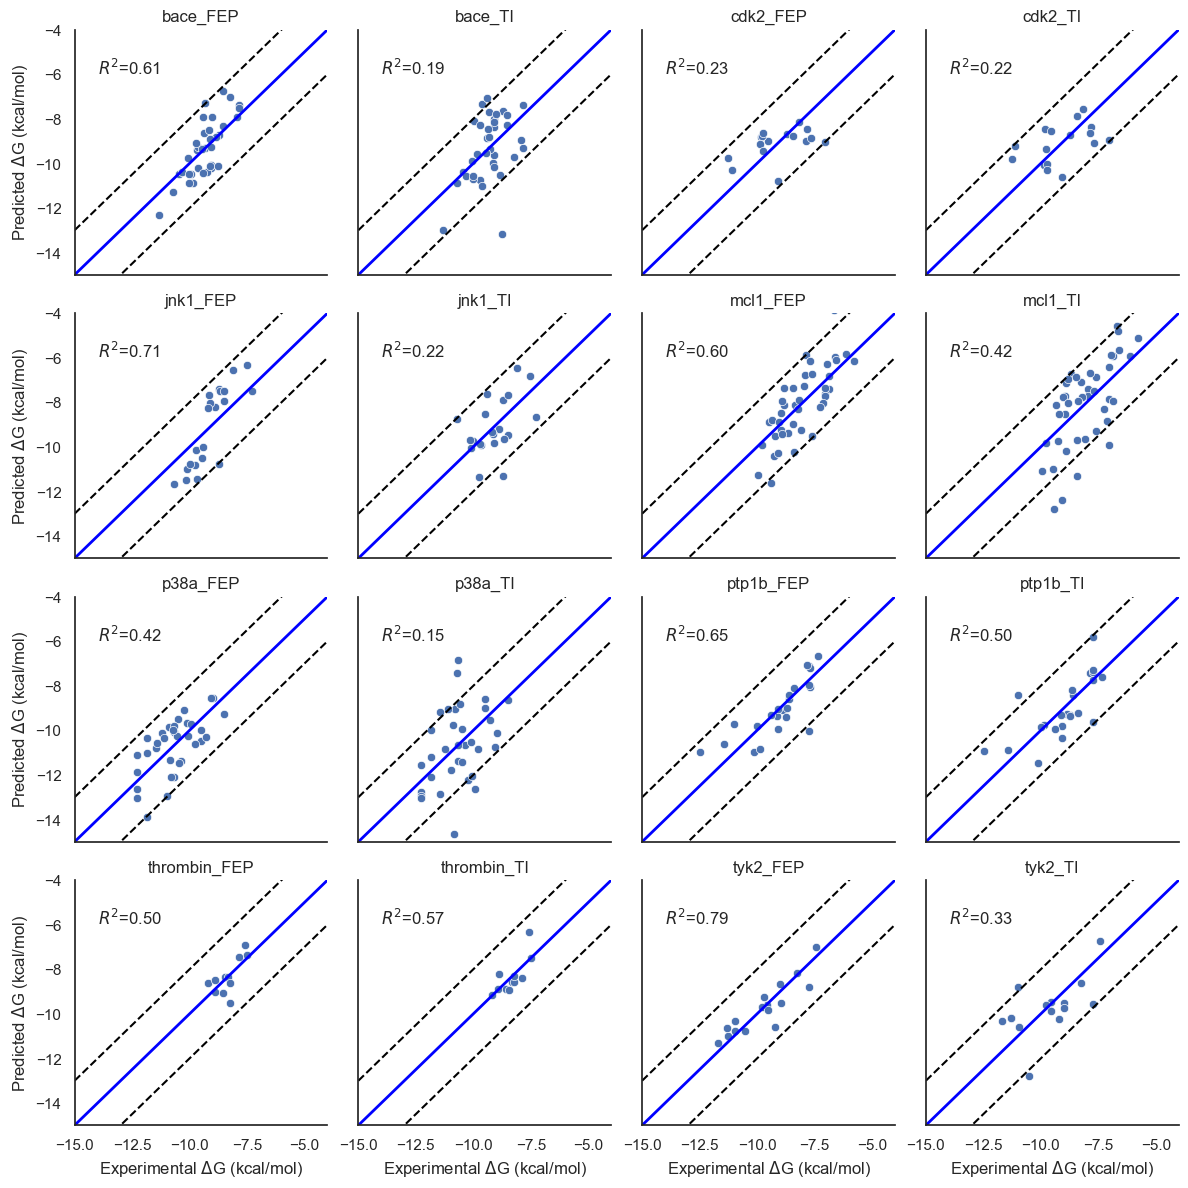

In [71]:
g = sns.FacetGrid(mdf, col="DataSet", col_wrap=4)
g.map_dataframe(draw_dG_facet, x="Experimental_dG", y="Predicted_dG")
g.set_titles(col_template="{col_name}")
g.set_xlabels(r"Experimental $\Delta$G (kcal/mol)")
g.set_ylabels(r"Predicted $\Delta$G (kcal/mol)")

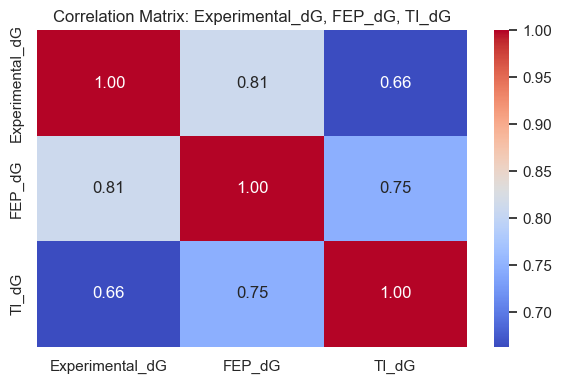

In [72]:
# 1. Correlation Matrix Heatmap
corr_df = big_df[["Experimental_dG", "FEP_dG", "TI_dG"]].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Experimental_dG, FEP_dG, TI_dG")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression

feature_cols = ["FEP_dG", "TI_dG"]
X = big_df[feature_cols]
y = big_df["Experimental_dG"]

# 2. Correlation Analysis
corr_matrix = X[selected_features_var].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.9)]
selected_features_corr = selected_features_var.drop(to_drop_corr)

final_selected_features = list(selected_features_corr)
final_selected_features

In [ ]:
# 3. Mutual Information
mi = mutual_info_regression(X[selected_features_corr], y)
mi_series = pd.Series(mi, index=selected_features_corr)
selected_features_mi = mi_series[mi_series > 0.01].index

In [75]:
final_selected_features = list(selected_features_mi)
final_selected_features

['FEP_dG', 'TI_dG']

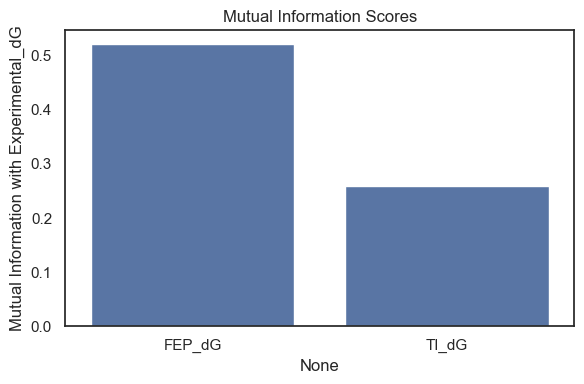

In [73]:
# 2. Mutual Information Scores Bar Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=mi_series.index, y=mi_series.values)
plt.ylabel("Mutual Information with Experimental_dG")
plt.title("Mutual Information Scores")
plt.tight_layout()
plt.show()